# news recommendation

### pre processing

In [41]:
import pandas as pd

df = pd.read_parquet('data05.parquet')
df["keywords"] = df["keywords"].map(lambda dic: {key: dic[key] for key in dic.keys() if dic[key] is not None and dic[key]["filter"] > 0.1})

In [42]:
df = df.iloc[0, :]
df

aliases                      [Banco Comercial Português, BCP]
news        [{'ExtractedText': 'DN   13 de Setembro de 200...
keywords    {'Angola': {'count': 135, 'date': {'200409': N...
Name: Banco Comercial Português, dtype: object

In [43]:
news = []
setences = []
for new in df["news"]:
    website_link = new["linkToArchive"].replace("/wayback/", "/noFrame/replay/")
    news.append(website_link)
    setence = ""
    for type in new["newsNER"].keys():
        try:
            setence += " ".join(set(new["newsNER"][type]))
        except:
            pass
    setences.append(setence)

### "clusters"

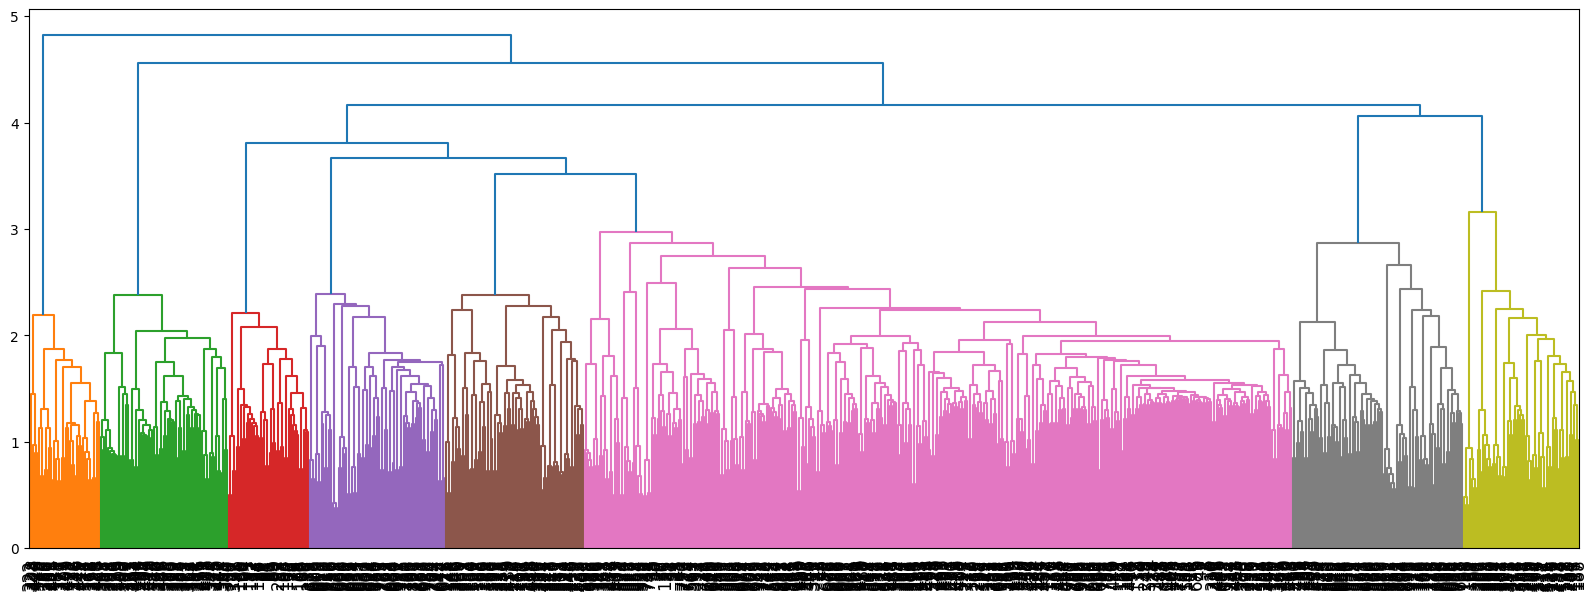

In [44]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Initialize with a 3-star rating for each text
ratings = np.array([3.0] * len(setences))

# Initialize TfidfVectorizer (you can limit vocabulary to your keywords if needed)
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(setences)

from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

linked = linkage(tfidf_matrix.toarray(), method='ward')
#print(linked)

plt.figure(figsize=(20, 7))
dendrogram(linked, labels=range(0, len(setences)), leaf_rotation=90, leaf_font_size=12)
plt.show()

### simulacao de avaliacao a toa

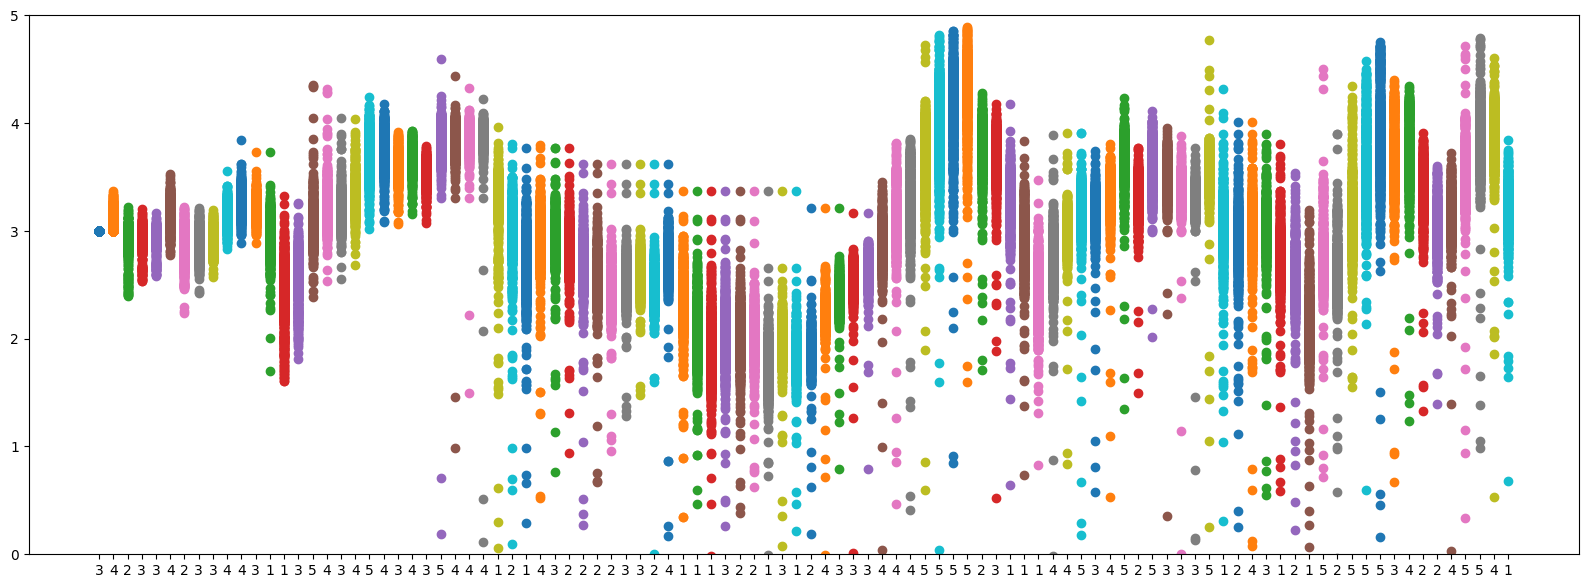

In [45]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

ratings = np.array([3.0] * len(setences))

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(setences)

def update_ratings(index, user_rating):
    global ratings
    # Compute similarity to all other texts
    similarity_scores = cosine_similarity(tfidf_matrix[index], tfidf_matrix).flatten()
    
    ratings += (user_rating - ratings) * (similarity_scores)**0.5
    ratings[index] = -1000
import random
plt.figure(figsize=(20, 7))
rated_news = []
for _ in range(100):
    weights = np.exp(np.array(ratings))  # Exponential gives higher prob to larger values
    weights = weights / weights.sum()  # Normalize to prob
    
    # Select an index based on the weights
    index = np.random.choice(len(ratings), p=weights)
    #print(news[index])
    #rating = int(input(f"Rating of {index}: "))
    rating = random.randint(1, 5)
    rated_news.append(rating)
    update_ratings(index, rating)
    plt.scatter([_]*len(ratings), ratings)
plt.xticks(ticks=range(100), labels=rated_news)
plt.ylim(0,5)
plt.show()

- correlacoes pouco heterogeneas

- devia dar mais "memoria" aos ratings

- dar uma especie de learning rate para mudar mais no inicio (aprender mais com o user), e dps estancar mais